## Documents 

Table of all versions of tasks.
* **version**: version number of the task update
* **documentId**: unique ID of the task. *version* is however the primary key of the table => Multiple rows could have the same ID.
* **title**
* **typeId**: ID of the type of the task. 33 types: *OPEN, CLOZE_TEXT_INPUT, CLOZE_TEXT_DROPDOWN, MULTIPLE_CHOICE, GRAMMAR, SPELLCHECK...*
* **createdTime**: timestamp of creation of the version of the task
* **authorId**
* **content**: a dict containing more information about the task (some fields in dict exist already as a separate column) <br> *id, <br>type, <br>hints (list), <br>title, <br>version, <br>description (text), <br>documentType (OPEN, CLUSTER,... same as type?), <br>solutionSteps (list)*
* **Status**: status of the task? *DRAFT, INITIAL, WORK_IN_PROGRESS...* 
* **aiStatus**: 
* **customerId, language, followUpTask, versionComment, feedbackComment**: sparse fields.

> **DocumentChildParent**

<hr>

## LatestDocumentVersions

The table containing the last versions of tasks.
* **version**
* **documentId**: no duplicates
* **createdTime**
  
<hr>

## Competences

The table of **Aspects**

* **id**
* **name**
* **description**
* **tenantId**: ID of the client
* **categoryId**: *Content, Deklination, Grammar, Spelling, Tempus, Modus, Wortart...* -sparse
* **type**: CONCEPT, MISCONCEPTION
* **groupId**
* **metaData**

> **TaskCompetences** is a join table associating *documentId* to *competenceId*.

<hr>

## AspectsConfigurations

The table of **Detectors**

* **id**: table PK
* **name**: detector name
* **aspectDetectorConfiguration**: dict containing different parameters, related to the detector type.
* **taskId**: one task can have multiple detectors, one detector per row.
* **topicId** -sparse
* **authorId**
* **configurationId, isEnabled**: sparse fields

<hr>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from bs4 import BeautifulSoup

In [3]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})
color_blind_colors = [
    "#00429d",  # Dark blue
    "#009c79",  # Dark green
    "#ff420e",  # Orange
    "#365e96",  # Blue
    "#ffbb00",  # Yellow
    "#a200ff",  # Purple
    "#01b1d2",  # Cyan
    "#00558c",  # Dark blue
    "#9e0638",  # Red
    "#00a03e",  # Green
    "#ffcd00",  # Yellow
    "#7a6fca",  # Blue
    "#3f3f3f",  # Gray
    "#af280e",  # Red
    "#c3d825",  # Green-yellow
    "#3a4276",  # Blue
    "#1f8a70",  # Green
    "#ff6800",  # Orange
    "#5b5a5a",  # Gray
    "#c49867",  # Brown
    "#827a04",  # Olive
    "#83a4d4",  # Light blue
    "#44a1c2",  # Blue
    "#c4b97f",  # Olive
    "#8a88a3",  # Purple
    "#da8137",  # Orange
    "#dc5f3b",  # Red-orange
    "#a67e2d",  # Yellow-brown
    "#b7aa89",  # Gray
    "#647d6e",  # Green
    "#6aabb1",  # Cyan
    "#a07f29",  # Yellow-brown
    "#d7a844",  # Yellow-orange
    "#6e764d"   # Olive
]

In [4]:
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

# Distribution of types

In [5]:
query = "SELECT * FROM DocumentTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)
df_types.head()

,typeId,type
0,26,BIT_MATCH
1,32,BIT_MATCH_MATRIX
2,27,BIT_MATCH_PICTURE
3,30,BIT_MULTIPLE_CHOICE
4,31,BIT_MULTIPLE_RESPONSE


In [6]:
query = "SELECT * FROM Documents"
df_tasks = pd.read_sql(query, cnx)
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')
df_tasks.head()

,version,documentId,title,typeId,createdTime,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,type
0,8,Dyx07vCUuWqWSiHC6V,,3,1531728113426,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
1,9,Dyx07vCUuWqWSiHC6V,Aufgabe PT1.2,3,1531728228715,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
2,20,HurIW8u0XJAWSiN5aR,,3,1531729909418,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
3,21,HurIW8u0XJAWSiN5aR,,3,1531730025414,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
4,24,HurIW8u0XJAWSiN5aR,Aufgabe PT1.6a,3,1531730573408,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT


In [7]:
query = "SELECT * FROM LatestDocumentVersions"
df = pd.read_sql(query, cnx)
df_latest_task_versions = pd.merge(df_tasks, df, how="inner", on=["version", "documentId"])
L = len(df_latest_task_versions)
df_latest_task_versions.head() 

,version,documentId,title,typeId,createdTime_x,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,type,id,createdTime_y
0,2325,PT1-11a-restored,Aufgabe PT1.11a,3,1535643328825,2,"{""id"": ""PT1-11a-restored"", ""type"": ""HIGHLIGHT""...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,2693,1534434704301
1,2388,7kQh-veLQfOanjx1QkhbKx,Aufgabe PT 2.14a,3,1535660365797,2,"{""id"": ""7kQh-veLQfOanjx1QkhbKx"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,1589,1532335779747
2,2395,d7SwsoVyAUP80fMioyhxzH,Aufgabe PT 2.14c,3,1535661392063,2,"{""id"": ""d7SwsoVyAUP80fMioyhxzH"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,2516,1532336772750
3,3786,4R58yTMxw8b5CK1F72eh0W,Musteraufgabe D_Markieren_Adjektive_3.4_WORT_A_1,3,1562516756370,32,"{""id"": ""4R58yTMxw8b5CK1F72eh0W"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,927,1559076209311
4,3788,2UiRhzBKL217r4pFiCA6Ek,Ersatz 1.6b_Markieren mit mehreren Farben,3,1562516867617,32,"{""id"": ""2UiRhzBKL217r4pFiCA6Ek"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,425,1555145282057


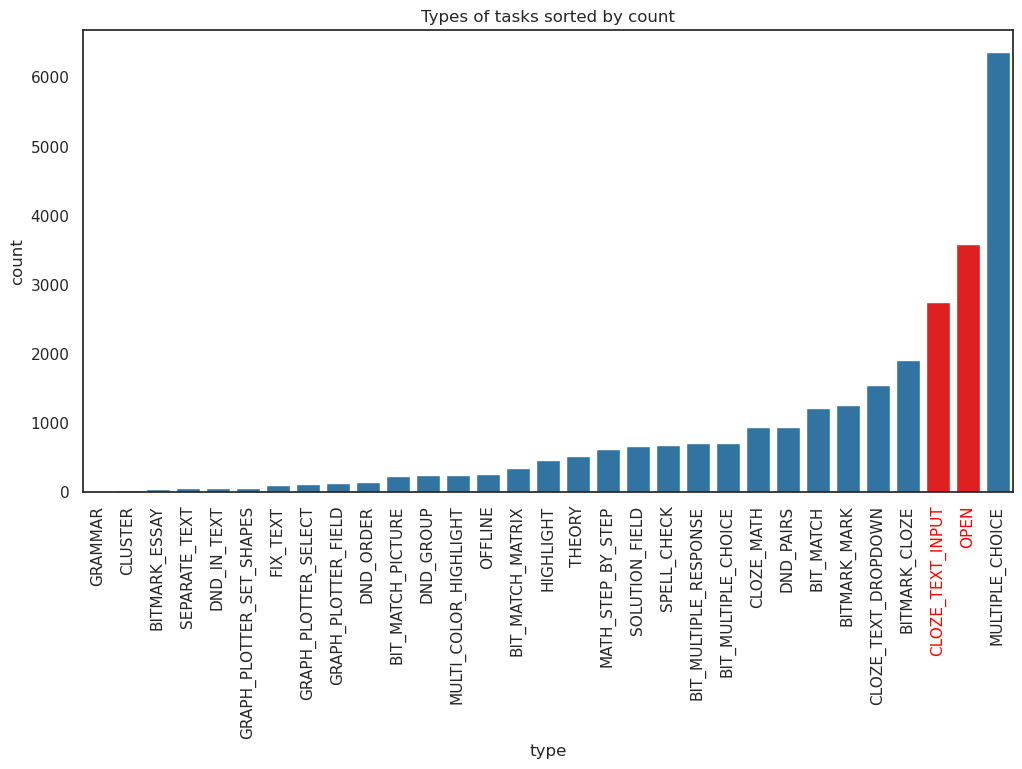

In [8]:
types_count = df_latest_task_versions[["type", "documentId"]].groupby("type").count().rename(columns={"documentId":"count"}).reset_index()

sns.set_theme(style='white', 
              rc={'figure.figsize':(12,6)})

colors = ['tab:blue' for x in types_count.type]
colors[-2] = 'red'
colors[-3] = 'red'

ax = sns.barplot(data=types_count,
                 x='type',
                 y="count",
                 order=types_count.sort_values('count').type, palette=colors)

plt.xticks(rotation=90)
ax.get_xticklabels()[-2].set_color("red")
ax.get_xticklabels()[-3].set_color("red")
title = plt.title("Types of tasks sorted by count")
ax.get_figure().savefig("figures/types_count_sorted.png", bbox_inches="tight") 


In [9]:
lowest_counts = types_count.sort_values(by="count", ascending=False)[16:] # ID 29 to 27
# lowest_counts = types_count[18:] # ID 29 to 20
p = lowest_counts['count'].sum() / types_count['count'].sum() * 100
print("The types of lowest counts (ID 29 to ID 27) correspond to {p:.2f}% of the number of tasks.".format(p=p))

The types of lowest counts (ID 29 to ID 27) correspond to 7.73% of the number of tasks.


<hr>

# Tenants

In [10]:
# Get titles and descriptions of last versions of tasks 
df = df_latest_task_versions[["title", "content"]]
df = pd.concat([df, df["content"].apply(json.loads).apply(pd.Series)], axis=1)
columns_to_keep = ["type", "clozeText", "description", "documentType", "clozeElements", "textWithMistakes", "solution", "language", "tenant", "topic"]
df_content = df[columns_to_keep]
# df_content.head()

In [11]:
# How many documents with solution ?
print("{:.2f}%".format(len(df_content["solution"].dropna()) / L * 100))

4.78%


In [12]:
# How many documents with language specified ? 
print("{:.2f}%".format(len(df_content["language"].dropna()) / L * 100))

43.78%


In [13]:
# How many documents with topic specified ? 
print("{:.2f}%".format(len(df_content["topic"].dropna()) / L * 100))

72.26%


In [14]:
# How many documents with tenant specified ? 
print("{:.2f}%".format(len(df_content["tenant"].dropna()) / L * 100))

96.79%


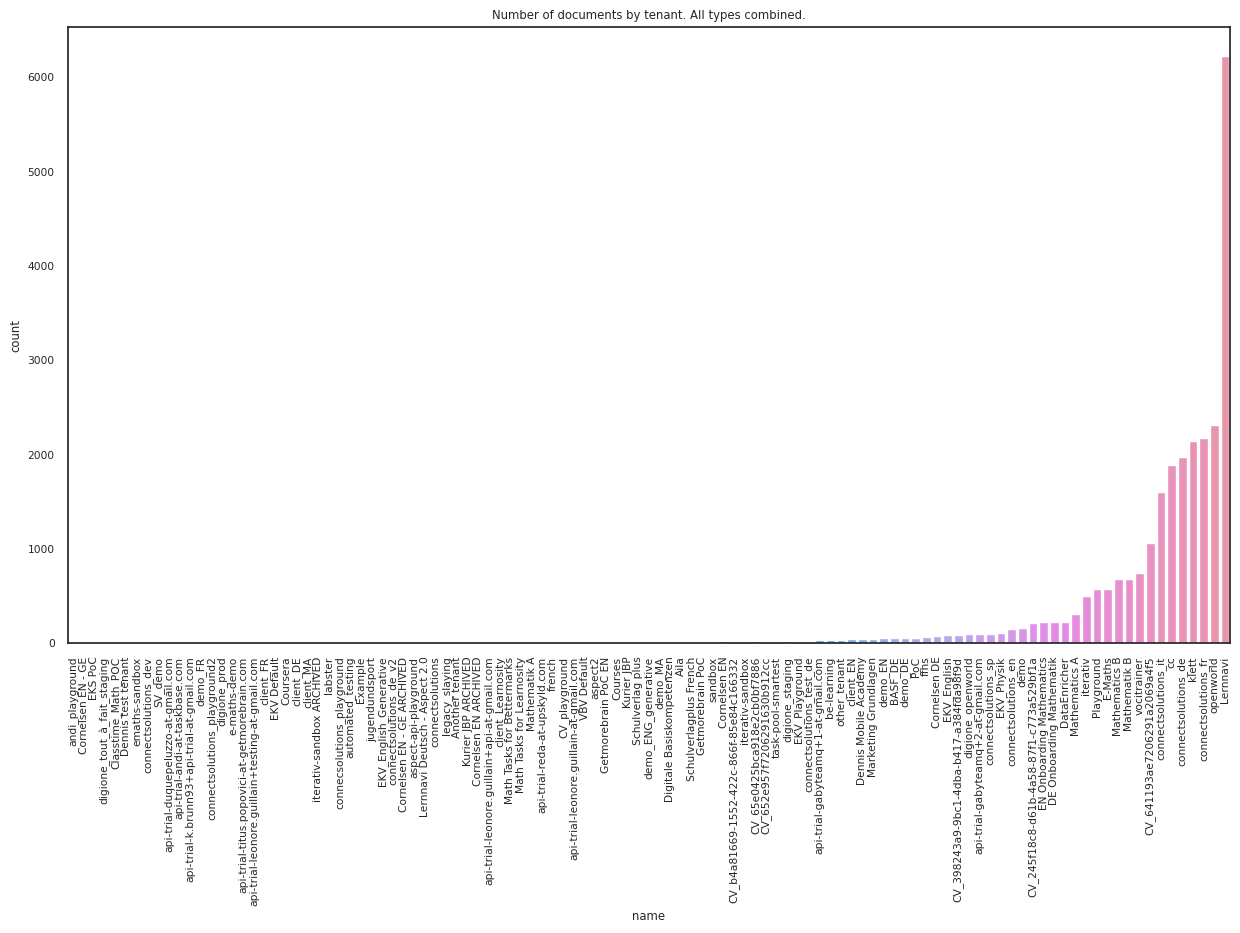

In [46]:
# Distribution of documents among tenants
tenants = df_content["tenant"].apply(pd.Series)
tenants_count = tenants.groupby(by="name").count()[["id"]].rename(columns={"id":"count"}).reset_index()

sns.set_theme(style='white', 
              font_scale=0.7, 
              rc={'figure.figsize':(15,8)})

ax = sns.barplot(data=tenants_count,
                 x="name",
                 y="count",
                 order=tenants_count.sort_values('count').name,
                 )
# ax.set_yscale("log")
plt.xticks(rotation=90)
title = plt.title("Number of documents by tenant. All types combined.")

In [16]:
df_content = pd.concat([df_content, tenants], axis=1)

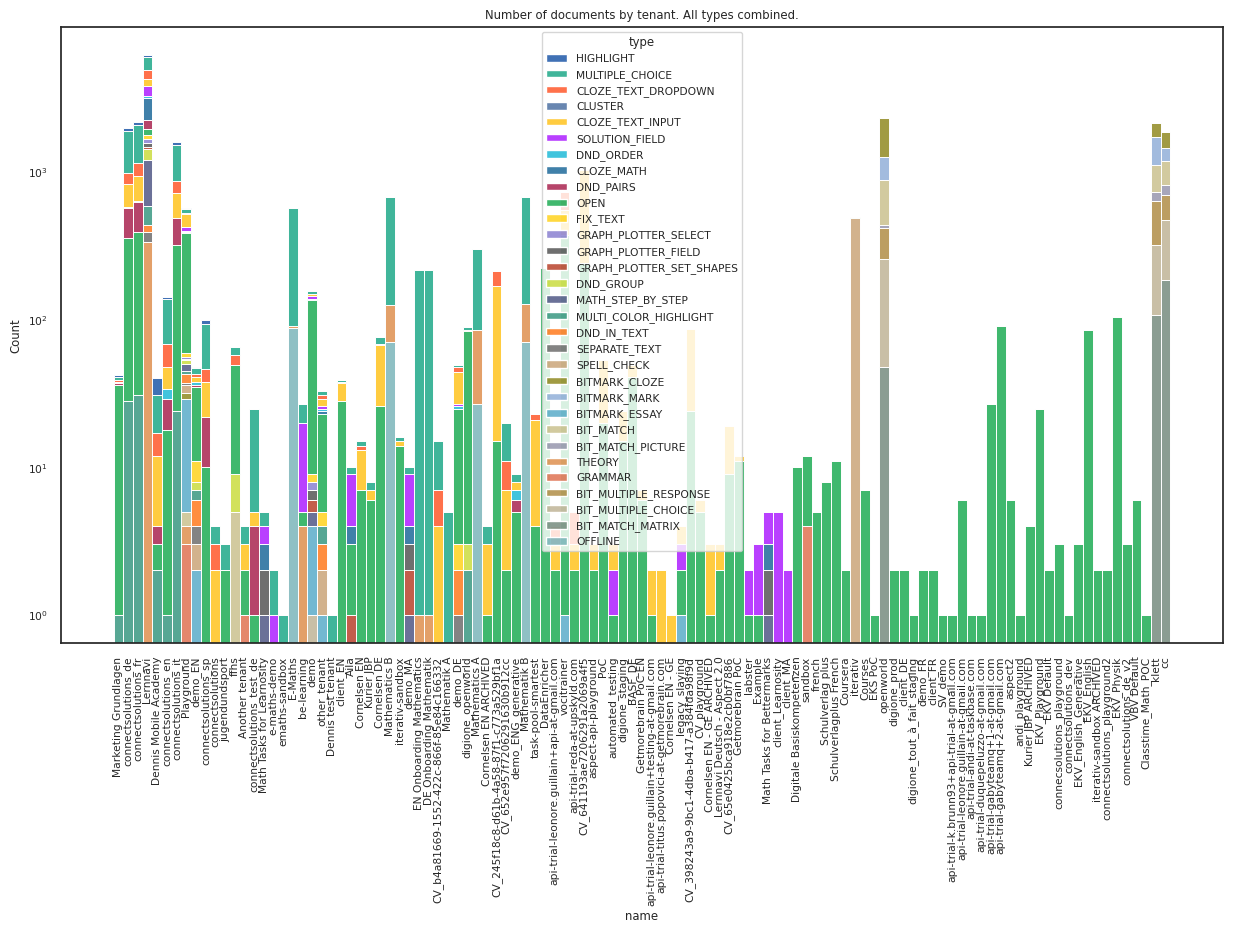

In [17]:
# Distribution of documents' types among tenants 
sns.set_theme(style='white', 
              font_scale=0.7, 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=df_content,
                  x="name",
                  hue="type",
                  multiple="stack", 
                  palette=color_blind_colors,
                 )
ax.set_yscale("log")
plt.xticks(rotation=90)
title = plt.title("Number of documents by tenant. All types combined.")

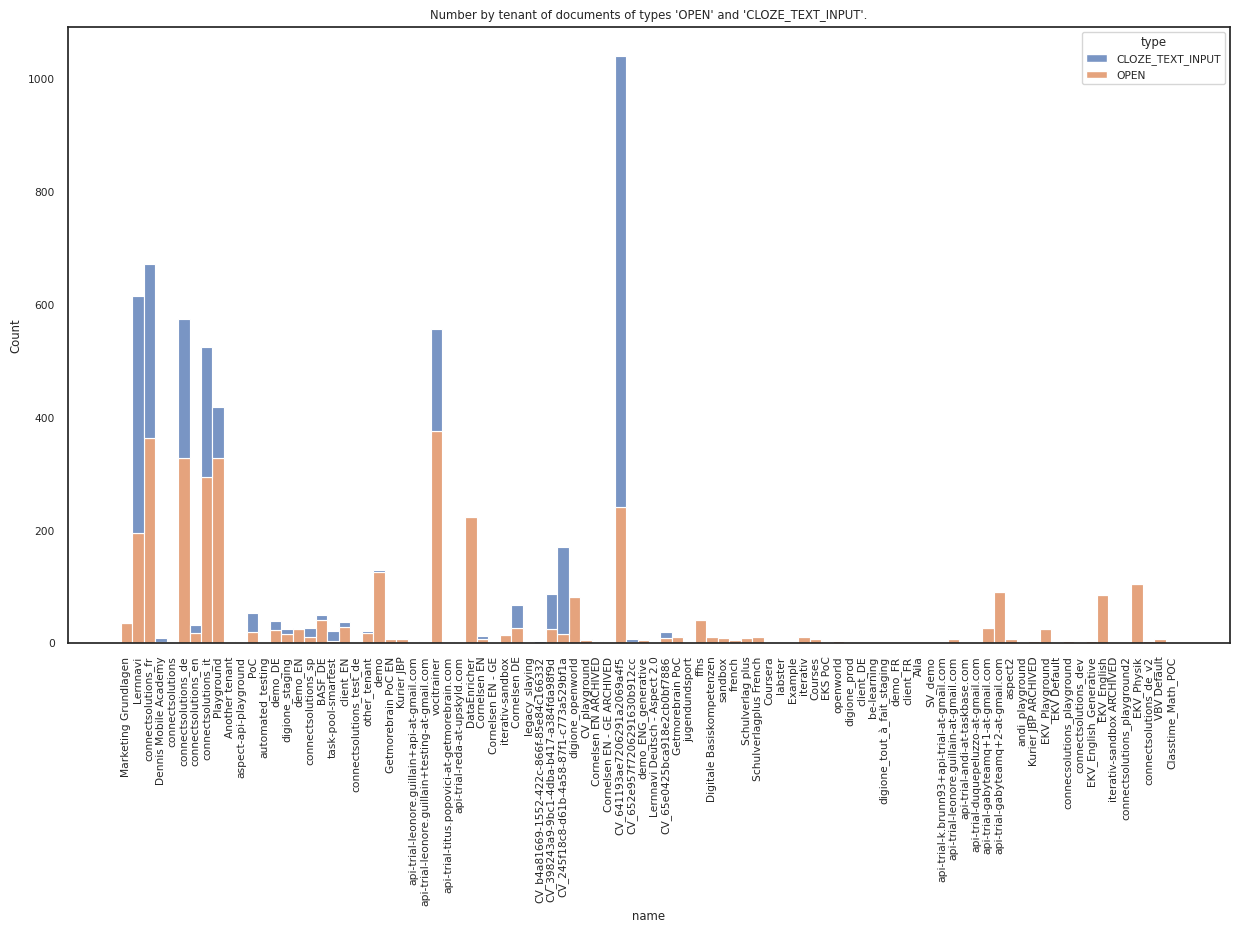

In [18]:
# Tenants with most CLOZE and OPEN tasks
task_types = ["OPEN", "CLOZE_TEXT_INPUT"]
df_cloze_open = df_content[df_content["type"].isin(task_types)]

ax = sns.histplot(data=df_cloze_open,
                  x="name",
                  hue="type",
                  multiple="stack"
                 )
# ax.set_yscale("log")
x = plt.xticks(rotation=90)
title = plt.title("Number by tenant of documents of types 'OPEN' and 'CLOZE_TEXT_INPUT'.")

In [19]:
# How many CLOZE OPEN with language specified ?
print("{:.2f}%".format(len(df_cloze_open["language"].dropna())/ len(df_cloze_open) * 100))

68.06%


In [20]:
# What is the portion of English and German cloze/open documents ? NaN included in total
print("{:.2f}%".format(len(df_cloze_open[df_cloze_open["language"].isin(["DE", "EN"])]) / len(df_cloze_open) * 100))

60.06%


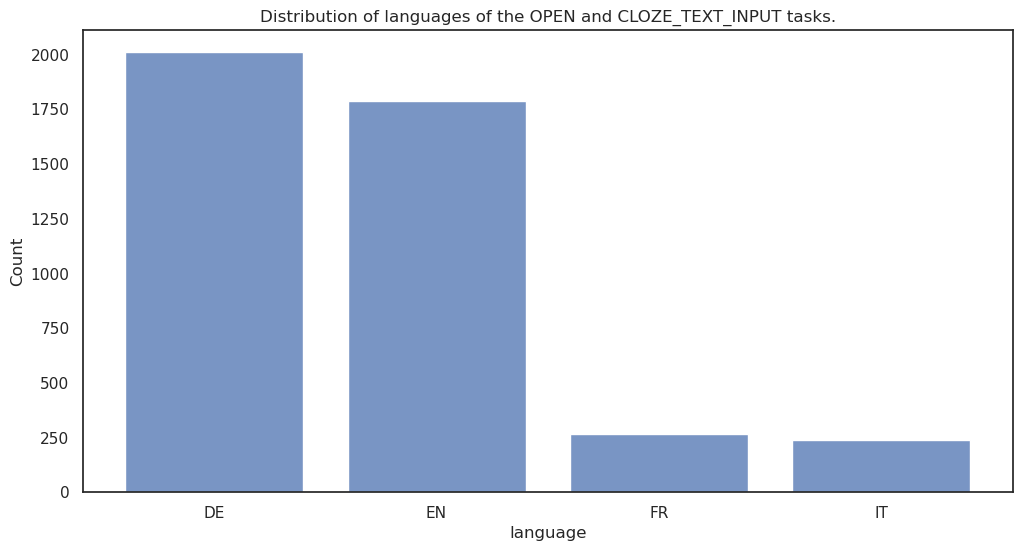

In [21]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(12,6)})

ax = sns.histplot(data=df_cloze_open,
                  x="language",
                  shrink=0.8)
title = plt.title("Distribution of languages of the OPEN and CLOZE_TEXT_INPUT tasks.")
ax.get_figure().savefig("figures/languages_distribution.png", bbox_inches="tight") 

**Cornelsen and EKV_Physik**

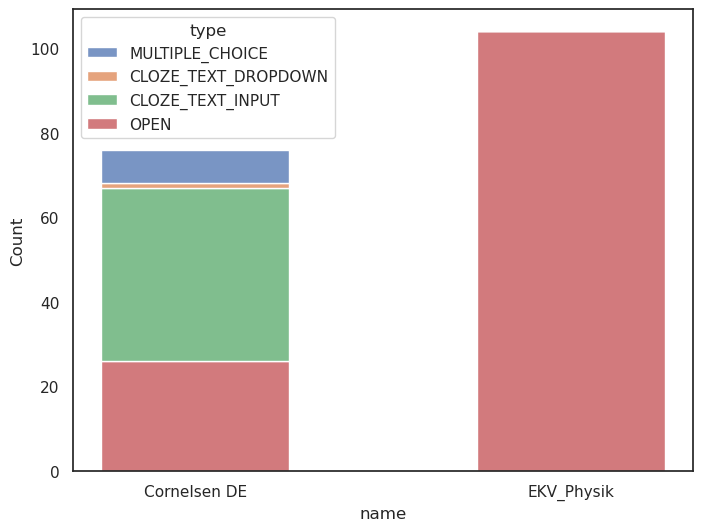

In [22]:
df_corn_ekv = df_content[df_content["name"].isin(["Cornelsen DE", "EKV_Physik"])]
sns.set_theme(style='white', 
              font_scale=1, 
              rc={'figure.figsize':(8,6)})

ax = sns.histplot(data=df_corn_ekv,
                  x="name",
                  hue="type",
                  multiple="stack",
                  shrink=0.5
                 )

# Content

In [23]:
# Lengths of descriptions => need pre-processing ? cleaning html tags 
clean_descriptions = df_cloze_open[["description", "language"]]
clean_descriptions["description"] = clean_descriptions["description"].apply(lambda str: BeautifulSoup(str, 'html.parser').get_text().strip())
clean_descriptions = pd.DataFrame(clean_descriptions.reset_index(drop=True))
clean_descriptions["word_count"] = clean_descriptions["description"].apply(lambda s: len(s.split()))
clean_descriptions.sort_values(by="word_count", inplace=True)
L = len(clean_descriptions)

In [24]:
df_cloze_open_EN = df_cloze_open[df_cloze_open["language"] == "EN"]
df_cloze_open_DE = df_cloze_open[df_cloze_open["language"] == "DE"]

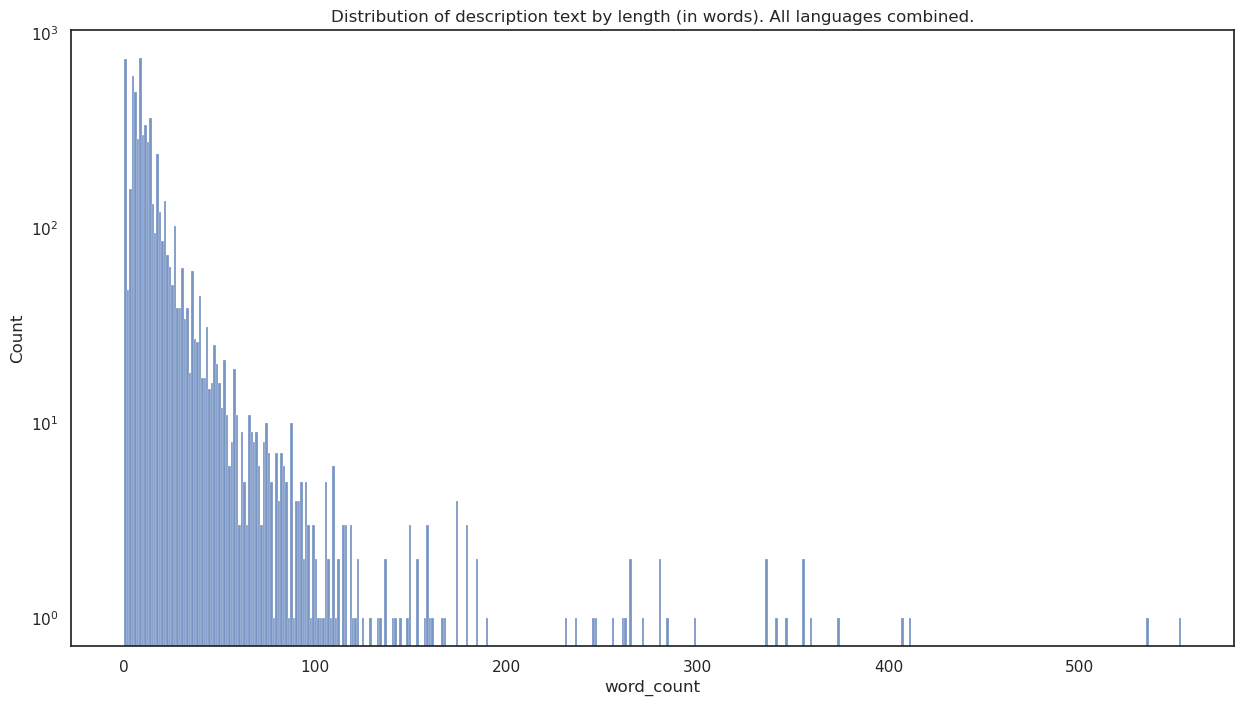

In [26]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=clean_descriptions,
                  x="word_count"
                 )
ax.set_yscale("log")
title = plt.title("Distribution of description text by length (in words). All languages combined.")

In [27]:
# How many empty descriptions ?
empty = clean_descriptions[clean_descriptions["word_count"] == 0]
print("{:.2f}%".format(len(empty) / L * 100))

9.94%


In [28]:
# How heavy is the tail ?
tail = clean_descriptions[clean_descriptions["word_count"] > 200]
print("{:.2f}%".format(len(tail) / L * 100))

0.41%


In [29]:
# How heavy is the tail ?
tail = clean_descriptions[clean_descriptions["word_count"] > 100]
print("{:.2f}%".format(len(tail) / L * 100))

1.47%


In [30]:
clean_descriptions.head()

,description,language,word_count
3162,,NaN,0
3696,,EN,0
566,,NaN,0
3697,,EN,0
3716,,EN,0


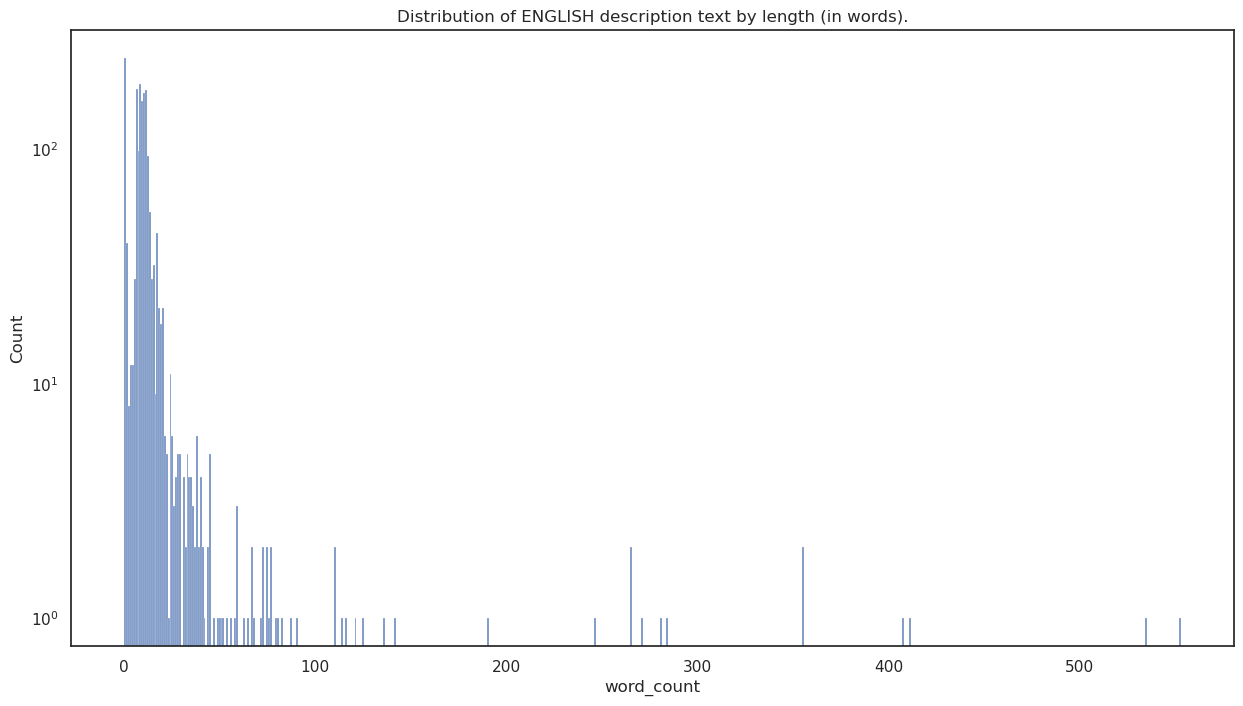

In [31]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=clean_descriptions[clean_descriptions["language"] == "EN"],
                  x="word_count"
                 )
ax.set_yscale("log")
title = plt.title("Distribution of ENGLISH description text by length (in words).")

In [32]:
df = clean_descriptions[clean_descriptions["language"] == "EN"]
L = len(df)
tail = df[df["word_count"] > 100]
print("{:.2f}%".format(len(tail) / L * 100))

1.17%


In [33]:
df = clean_descriptions[clean_descriptions["language"] == "EN"]
L = len(df)
tail = df[df["word_count"] > 50]
print("{:.2f}%".format(len(tail) / L * 100))

2.63%


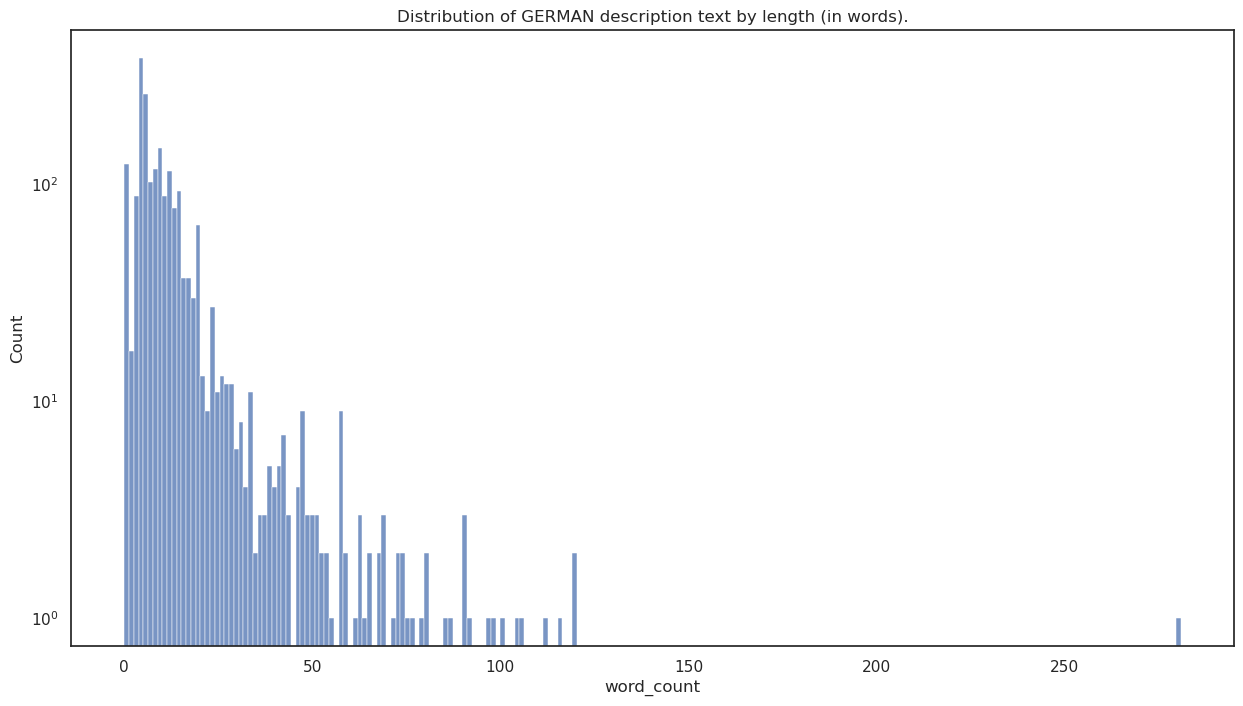

In [34]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=clean_descriptions[clean_descriptions["language"] == "DE"],
                  x="word_count"
                 )
ax.set_yscale("log")
title = plt.title("Distribution of GERMAN description text by length (in words).")

In [35]:
df = clean_descriptions[clean_descriptions["language"] == "DE"]
L = len(df)
tail = df[df["word_count"] > 100]
print("{:.2f}%".format(len(tail) / L * 100))

0.35%


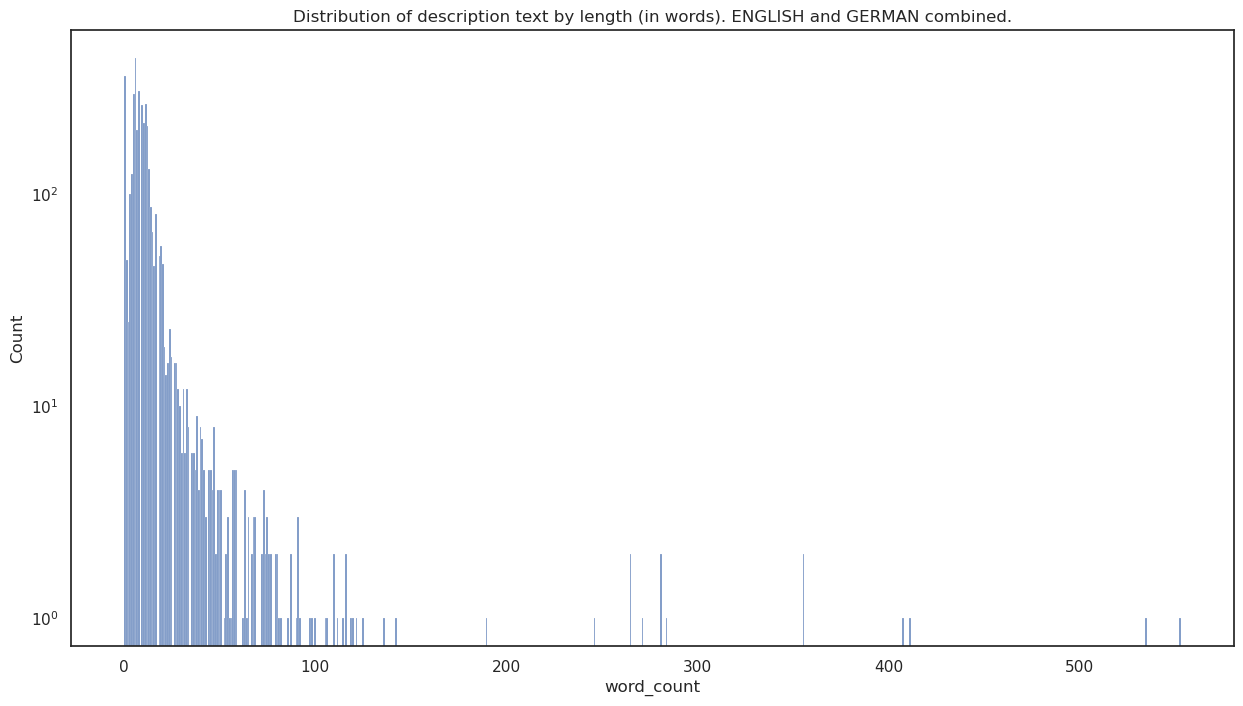

In [36]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=clean_descriptions[clean_descriptions["language"].isin(["EN", "DE"])],
                  x="word_count"
                 )
ax.set_yscale("log")
title = plt.title("Distribution of description text by length (in words). ENGLISH and GERMAN combined.")

In [37]:
df = clean_descriptions[clean_descriptions["language"].isin(["EN", "DE"])]
L = len(df)
tail = df[df["word_count"] > 100]
print("{:.2f}%".format(len(tail) / L * 100))

# How many empty descriptions ?
empty = df[df["word_count"] == 0]
print("{:.2f}%".format(len(empty) / L * 100))

# How many short descriptions ?
empty = df[df["word_count"] < 10]
print("{:.2f}%".format(len(empty) / L * 100))

0.74%
9.48%
56.96%


> The distribution of the length of task description (in number of words) is heavy-tailed. Descriptions of more than 100 words count for less than 1% of the dataset and so can be discarded. Empty descriptions however count for almost 10% of the dataset.
> More than half of the dataset of English and German tasks have short descriptions, of less than 10 words.

**Topics**

In [38]:
df_cloze_open_topics = df_cloze_open_EN["topic"].apply(pd.Series)

In [39]:
df_cloze_open_topics.dropna(subset=["name"]).name.unique()

array(['Idiomatismen', 'Grammar', 'IT_L_CO', 'FR_L_CO',
       '1.Structuration de la présentation',
       'Sprichwörter und Redewendungen',
       'Zeitform und grammatische Kategorie', 'Wortfeld', 'Stammprinzip',
       'Deklination', '13. Conoscere i propri limiti',
       '18. Ricerca sullo sviluppo',
       '15. Trasferimento di lezioni apprese e riflessioni',
       '1. Impatto personale delle esperienze', 'EN - EN', 'Konnektoren',
       '9. Engager des mesures contre les dysfonctionnements', 'Modus',
       'Steigerung und Steigerbarkeit', 'Schwache und starke Flexion',
       'Adjektive', 'Main Topic', 'Helvetismen und Standardsprache',
       '7. Uso corretto degli strumenti di guida',
       '3. Percevoir les signes avant-coureurs de conflit',
       '9. Mettre en pratique ses connaissances en matière de gestion de conflit dans son activité de conduite',
       'EN - DE', 'English', 'EN_Content', 'Language learning', 'Content',
       'Deutsch', 'Grundlegende Konstruktionen

<hr>

# Aspects

In [44]:
pd.set_option('display.max_rows', 500)
query = "SELECT * FROM Tenants"
df = pd.read_sql(query, cnx)
# df[df["lang"] == "DE"]

In [41]:
query = "SELECT * FROM Competences"
df_aspects = pd.read_sql(query, cnx)
# df_aspects.head()

df_aspects_cornelsen = df_aspects[df_aspects["tenantId"]==95]
df_aspects_ekvphysik = df_aspects[df_aspects["tenantId"]==140]
# df_aspects_cornelsen.head()
df_aspects_ekvphysik.head()

,id,name,description,tenantId,categoryId,type,groupId,metaData
6789,100769,EM_Magnet,Der/Die Lernende kennt alle Informationen zum ...,140,NaN,CONCEPT,135946.0,None
6820,100920,EM_Anziehungskraft,"Der/Die Lernende hat erwähnt, dass unterschied...",140,NaN,CONCEPT,135946.0,None
6821,100921,EM_Anziehungskraft,"Der/Die Lernende hat nicht erwähnt, dass unter...",140,NaN,MISCONCEPTION,135946.0,None
6822,100922,EM_magnetisieren,Der/ die Lernende kennt alle Informationen übe...,140,NaN,CONCEPT,135946.0,None
6823,100923,EM_magnetisieren,Der/ die Lernende kennt nicht alle Information...,140,NaN,MISCONCEPTION,135946.0,None


In [42]:
df_aspects["description"][6790]

'Die/Der Lernende hat einen Fehler bei der Kommasetzung gemacht.'

<hr>

# Detectors

In [43]:
query = "SELECT * FROM AspectConfigurations"
df_detectors = pd.read_sql(query, cnx)
df_detectors.head()

,id,name,aspectDetectorConfiguration,taskId,topicId,authorId,configuratorId,isEnabled
0,109,Entailment,"{""type"": ""ENTAILMENT_FREEFORM_TEXT"", ""paramete...",2FVWlAlScuC9XzyS5SarpA,NaN,24183,None,1
1,111,Universal AI,"{""type"": ""GPT3_FREEFORM"", ""parameters"": {""PROM...",4M6yoJCBEbQ6zaztY5bG1U,NaN,24183,None,1
2,113,Entailment,"{""type"": ""ENTAILMENT_FREEFORM_TEXT"", ""paramete...",7Aogxgxr1hM80XInQ8ZGAo,NaN,9443,None,1
3,114,Is Mathematically Equivalent,"{""type"": ""IS_EQUAL_SYMBOLIC_SOLUTION_FIELD"", ""...",94aOVOXLgfx6kujfGUjQ87,NaN,9443,None,1
4,119,Entailment,"{""type"": ""ENTAILMENT_FREEFORM_TEXT"", ""paramete...",8XOoRbXxyor6yQA8GCmawe,NaN,9443,None,1
